# Building a Recurrent Neural Network for music generation

Chúng ta sẽ huấn luyện một *model* để học các nốt nhạc trong bản nhạc ban đầu và sau đó sử dụng model để tạo một bản nhạc mới.

#### [ABC notation](https://en.wikipedia.org/wiki/ABC_notation)

**ABC notation** là một hình thức tốc ký của ký hiệu âm nhạc (musical notation). Về cơ bản nó sử dụng các ký tự A đến G để đại diện cho các nốt được đưa vào. Với các yếu tố khác được sử dụng để thêm giá trị gia tăng trên các giá trị này như: sharp, flat, length of the note, key, ornamentation. Bắt đầu bằng một bộ ký tự ASCII có thể tạo điều kiện chia sẻ nhạc trực tuyến và cũng đã thêm một ngôn ngữ mới và đơn giản cho các nhà phát triển phần mềm, không giống như các ký hiệu khác được thiết kế dễ dàng. Ký hiệu ABC trước đó được xây dựng, chuẩn hóa và thay đổi để phù hợp với bàn phím hơn và ký tự ASCII được cài đặt bởi Chris WalShaw , với sự trợ giúp từ nhiều nguồn.    
Thiết kế ban đầu để sử dụng với các giai điệu dân gian và truyền thống có nguồn gốc Tây Âu, ví dụ như Anh, Ailen, Scotland, thường là những giai điệu đơn ca có thể được viết bởi một nhạc sĩ theo ký hiệu chuẩn, công việc của Chris Walshaw và những người khác đã mở chúng với một danh sách các ký tự và tiêu đề tăng theo cú pháp cũng có thể hỗ trợ *metadata* cho mỗi giai điệu.    
Ký hiệu ACB dựa trên ASCIIm bất kỳ trình soạn thảo văn bản nào cũng có thể được sử dụng để chỉnh sửa mã. Thậm chí, hiện nay có rất nhiều phần mềm ký hiệu ABC cung cấp nhiều tính năng, bao gồm khả năng đọc và xử lý ký hiệu ABC thành các tệp MIDI và ký hiệu "dotted". Phần mềm như vậy có sẵn cho hầu hết các hệ thống máy tính bao gồm Microsoft Winddowwns, Unix/Linux, Macintosh, Palm OS và dựa trên web.

### Dependencies

In [1]:
import tensorflow as tf
import setup
import util
import numpy as np
import os
import time
import functools
from IPython import display as ipythondisplay
from tqdm import tqdm


### Dataset

Dataset gồm 1000 bài hát dân gian, biểu diễn trong *ABC notation*. 

In [2]:
# Download the dataset
songs = setup.load_training_data()

example_song = songs[0]
print("Example song: ")
print(example_song)

Found 816 songs in text
Example song: 
X:2
T:An Buachaill Dreoite
Z: id:dc-hornpipe-2
M:C|
L:1/8
K:G Major
GF|DGGB d2GB|d2GF Gc (3AGF|DGGB d2GB|dBcA F2GF|!
DGGB d2GF|DGGF G2Ge|fgaf gbag|fdcA G2:|!
GA|B2BG c2cA|d2GF G2GA|B2BG c2cA|d2DE F2GA|!
B2BG c2cA|d^cde f2 (3def|g2gf gbag|fdcA G2:|!


Chúng ta có thể dễ dàng chuyển đổi một bài hát trong *ABC notation* thành một bản audio. Hãy lưu ý khi chạy bước này vì nó sẽ mất một thời gian kha khá của bạn đấy.

In [3]:
'''
  Convert the ABC notation to audio file and listen to it
'''
# mdl.lab1.play_song(example_song)

'\n  Convert the ABC notation to audio file and listen to it\n'

Một suy nghĩa quan trọng về ký hiệu âm nhạc này là nó không chỉ đơn giản là chứa các thông tin trên các nốt đang được phát mà nó có thể còn thêm các thông tin khác ví dụ như *title, key* và *tempo*. Vậy làm thế nào để số lượng các ký tự khác nhau có trong tệp văn bản ảnh hưởng đến độ phức tạp của vấn học tập? Nó sẽ sớm trở nên quan trọng khi chúng ta tạo một con số đại diện cho ký tự văn bản

In [4]:
# Join our list of song strings into a single string containing all songs
songs_joined = "\n\n".join(songs)
# find all unique characters in the joined string
vocab = sorted(set(songs_joined))
print("There are", len(vocab), "unique characters in the dataset")

There are 83 unique characters in the dataset


### Process the dataset for the learning task

Lùi lại một bước và xem xét quá trình dự đoán. Chúng ta thử huấn luyện một *RNN model* để học các mẫu trong *ABC music* và sau đó sử dụng *model* để tạo một bản nhạc mới dựa trên những thông tin đã học được.    
Yêu cầu cho *model* đó là: Đưa vào một ký tự hoặc một chuỗi các ký tự nối tiếp nhau và yêu cầu *model* dự đoán xem ký tự tiếp theo sẽ xuất hiện là ký tự nào? Chúng ta sẽ huấn luyện *model* để trình bày nhiệm vụ này.    
Để đạt được điều này, chúng ta sẽ đưa input là một chuỗi các ký tự nối tiếp nhau cho *model*, và huấn luyện *model* để dự đóan output, nghĩa là, theo dõi các ký tự tiếp theo sau đó ở mỗi bước. *RNNs* cung cấp một trạng thái nội bộ tùy thuộc vào các yếu tố được nhìn thấy trước đó. Vì vậy thông tin về tất cả ký tự nhìn thấy cho đến một thời điểm nhất định sẽ được đưa vào bên trong quá trình dự đoán.

### Vectorize the text

Trước khi chúng ta bắt đầu huấn luyện *RNN model*, chúng ta sẽ cần tạo một số lượng đại diện cho ký tự mẫu trong dataset. Để làm điều đó, chúng ta sẽ tạo hai bảng tra cứu: một để ánh xạ các ký tự thành số, và bảng thứ hai để ánh xạ số về ký tự. Chúng ta chỉ cần định nghĩa các ký tự duy nhất trong một văn bản.

In [5]:
'''
  Define numerical representation of text
  Create a mapping from character to unique index
  For example, to get the index of the character "d"
  we can evalute char2idx["d"]
'''
char2idx = {u:i for i, u in enumerate(vocab)}
'''
  Create a mapping from indices to characters.
  This inverse of char2idx and allows us to convert back
  from unique index to the character in our vocabulary
'''
idx2char = np.array(vocab)

Nó đưa vào một số nguyên đại diện cho mỗi ký tự. Quan sát các ký tự duy nhất trong văn bản là ánh xạ của các chỉ số từ 0 đến len(unique). Hãy xem con số đại diện cho tập dữ liệu: 

In [6]:
number = 5
for char, _ in zip(char2idx, range(number)):
  print(' {:4s}: {:3d},'.format(repr(char), char2idx[char]))

 '\n':   0,
 ' ' :   1,
 '!' :   2,
 '"' :   3,
 '#' :   4,


In [7]:
def vectorize_string(string):
  result = np.array([char2idx[char] for char in string])
  return result

In [8]:
vectorized_songs = vectorize_string(songs_joined)
vectorized_songs

array([49, 22, 14, ..., 22, 82,  2])

In [9]:
print('{} ---characters mapped to int ----> {}'.format(
    repr(songs_joined[:10]), vectorized_songs[:10]
))
# check that vectorized_songs is a numpy array
assert isinstance(vectorized_songs, np.ndarray), "returned result should be a numpy array"

'X:2\nT:An B' ---characters mapped to int ----> [49 22 14  0 45 22 26 69  1 27]


### Create training examples and targets

Bước tiếp theo là việc phân chia văn bản vào một *example sequences* và tập này sẽ được sử dụng trong quá trình huấn luyện. Với mỗi *sequence* chúng ta đưa vào *RNN* sẽ chứa *seq_length characters* từ văn bản. Chúng ta cần định nghĩa một *sequence* mục tiêu cho mỗi *sequence* đầu vào, cái mà chúng ta sẽ sử dụng để huấn luyện *RNN* cho việc dự đoán ký tự xuất hiện tiếp theo. Ví dụ với mỗi input, mục tiêu tương ứng sẽ lưu trữ cùng độ dài của văn bản, ngoại trừ việc dịch chuyển một ký tự sang bên phải.  
Để làm điều này, chúng ta sẽ chia văn bản thành nhiều phần của *seq_length+1*. Giả sử *seq_length* là 4 và văn bản của chúng ta là "Hello". Sau đó, *input sequence* của chúng ta là *Hell* và *sequence* mục tiêu là "ello".  
Sau đó chúng ta sẽ chuyển các chỉ mục ký tự này thành chuỗi có kích thước mong muốn.

In [10]:
# Batch definition to create training examples
def get_batch(vectorized_songs, seq_length, batch_size):
  # the length of the vectorized songs string
  n = vectorized_songs.shape[0] - 1
  # randomly choose the starting indices for the examples in the training batch
  idx = np.random.choice(n-seq_length, batch_size)
  print("idx: ", idx)
  # construct a list of input sequences for the training batch 
  input_batch = [vectorized_songs[i: i+seq_length] for i in idx]
  print("input_batch: ", input_batch)
  # construct a list of output sequences for the training batch
  output_batch = [vectorized_songs[i+1 : i+seq_length+1] for i in idx]
  print("output_batch: ", output_batch)

  # x_batch, y_batch provide the true inputs and targets for network training
  x_batch = np.reshape(input_batch, [batch_size, seq_length])
  y_batch = np.reshape(output_batch, [batch_size, seq_length])
  print("x_batch: ", x_batch)
  print("y_batch: ", y_batch)
  return x_batch, y_batch

In [11]:
# Perform some simple tests to make sure your batch function is working properly!
test_args = (vectorized_songs, 10, 2)
if not setup.test_batch_func_types(get_batch, test_args) or \
   not setup.test_batch_func_shapes(get_batch, test_args) or \
   not setup.test_batch_func_next_step(get_batch, test_args):
  print("[INFO] could not pass tests")
else:
  print("[INFO] passed all tests")

idx:  [78917  9476]
input_batch:  [array([26, 11, 82, 27, 32,  1, 32, 25, 26, 82]), array([ 2,  0, 59, 14, 59, 14,  1, 59, 14, 58])]
output_batch:  [array([11, 82, 27, 32,  1, 32, 25, 26, 82, 27]), array([ 0, 59, 14, 59, 14,  1, 59, 14, 58, 59])]
x_batch:  [[26 11 82 27 32  1 32 25 26 82]
 [ 2  0 59 14 59 14  1 59 14 58]]
y_batch:  [[11 82 27 32  1 32 25 26 82 27]
 [ 0 59 14 59 14  1 59 14 58 59]]
[PASS] test_batch_func_types
idx:  [ 53587 168452]
input_batch:  [array([61, 82, 59, 26, 31,  1, 29, 31, 26, 82]), array([59, 58,  9, 73, 60, 60, 67,  9, 15, 15])]
output_batch:  [array([82, 59, 26, 31,  1, 29, 31, 26, 82, 59]), array([58,  9, 73, 60, 60, 67,  9, 15, 15, 13])]
x_batch:  [[61 82 59 26 31  1 29 31 26 82]
 [59 58  9 73 60 60 67  9 15 15]]
y_batch:  [[82 59 26 31  1 29 31 26 82 59]
 [58  9 73 60 60 67  9 15 15 13]]
[PASS] test_batch_func_shapes
idx:  [ 94693 160537]
input_batch:  [array([62, 82, 60, 27, 27, 14,  1, 59, 60, 61]), array([26, 32, 32, 14, 82, 32, 30, 29, 30,  1])]
ou

Đối với mỗi vector này, mỗi chỉ mục được xử lý tại một bước duy nhất. Vì vậy, cho ví dụ tại bước 0, *model* nhận giá trị đầu tiên trong chuỗi, và thử dự đoán chỉ mục của giá trị tiếp theo. Tại bước tiếp theo, làm lại tương tự bước 0, nhưng *RNN* xét thông tin từ bước trước, cập nhật trạng thái, thêm nó vào input hiện tại.  
Chúng ta xem thử một vài quá trình hoạt động của nó qua một vài ký tự xuất hiện đầu tiên trong văn bản.

In [12]:
x_batch, y_batch = get_batch(vectorized_songs, seq_length=5, batch_size=1)
for i, (input_idx, target_idx) in enumerate(zip(np.squeeze(x_batch), np.squeeze(y_batch))):
  print("Step {:3d}".format(i))
  print("Input: {} ({:s})".format(input_idx, repr(idx2char[input_idx])))
  print("Expected output: {}, ({:s})".format(target_idx, repr(idx2char[target_idx])))
  print("------------------")

idx:  [117652]
input_batch:  [array([26,  1, 27, 14, 32])]
output_batch:  [array([ 1, 27, 14, 32, 27])]
x_batch:  [[26  1 27 14 32]]
y_batch:  [[ 1 27 14 32 27]]
Step   0
Input: 26 ('A')
Expected output: 1, (' ')
------------------
Step   1
Input: 1 (' ')
Expected output: 27, ('B')
------------------
Step   2
Input: 27 ('B')
Expected output: 14, ('2')
------------------
Step   3
Input: 14 ('2')
Expected output: 32, ('G')
------------------
Step   4
Input: 32 ('G')
Expected output: 27, ('B')
------------------


### The Recurrent Neural Network (RNN) model

Bây giờ chúng ta sẵn sàng cho việc định nghĩa và huấn luyện một *RNN model* trên bộ dữ liệu *ABC music* đã có sẵn, và sau đó sử dụng *model* đã được huấn luyện này để phát sinh một bản nhạc. Chúng ta sẽ huấn luyện cho *RNN* bằng việc sử dụng *batches ò song snippets* từ tập dữ liệu, cái mà chúng ta đã tạo ra từ phần trên.  
*Model* cơ bản dựa trên kiến trúc mạng *LSTM*. Chúng ta sử dụng một *state vector* để chứa những thông tin chính về những mối quan hệ tạm thời giữa các ký tự liên tiếp. Kết quả cuối cùng của *LSTM* sau đó đưa vào một *fully connected Dense layer* nơi mà chúng ta sẽ tạo ra một *softmax* trên mỗi ký tự trong từ điển và sau đó lấy mẫu từ phân phối này để dự đoán cho ký tự tiếp theo.  
Ở đây, chúng ta sử dụng [tf.keras.Sequential](https://www.tensorflow.org/api_docs/python/tf/keras/Sequential) để định nghĩa *model*. 3 Tầng được sử dụng để định nghĩa *model*:  
* [tf.keras.layers.Embedding](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Embedding): Đây là *input layer*, bao gồm bảng tra cứu ánh xạ những con số đại diện cho mỗi ký tự đến một *vector* với*embedding_dim dimensions*.
* [tf.keras.layers.LSTM](https://www.tensorflow.org/api_docs/python/tf/keras/layers/LSTM): *LSTM network*, với kích thước *units=rnn_units*.
* [tf.keras.layers.Dense](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dense): *ouput layers*, với *vocab_size*.

![SEQUENCE_LENGTH](https://camo.githubusercontent.com/0889754930f51dcf4616d81ad097ecec05ba78f1/68747470733a2f2f7261772e67697468756275736572636f6e74656e742e636f6d2f61616d696e692f696e74726f746f646565706c6561726e696e672f323031392f6c6162312f696d672f6c73746d5f756e726f6c6c65642d30312d30312e706e67)

#### Define the RNN model

Bây giờ, chúng ta sẽ định nghĩa một hàm dể sử dụng cho việc xây dựng *model*

In [13]:
def LSTM(rnn_units):
  return tf.keras.layers.LSTM(
      rnn_units,
      return_sequences=True,
      recurrent_initializer = 'glorot_uniform',
      recurrent_activation='sigmoid',
      stateful=True,
  )

In [14]:
'''
  Defining the RNN model
  Add LSTM and Dense layers to define the RNN model using the Sequential API.
'''
def build_model(vocab_size, embedding_dim, rnn_units, batch_size):
  model = tf.keras.Sequential([
    # Layer 1: Embedding layer to transform indices into dense vectors of a fixed embedding size
    tf.keras.layers.Embedding(vocab_size, embedding_dim, batch_input_shape=[batch_size, None]),
    # Layer2: LSTM with 'run_units' number of units. 
    LSTM(rnn_units),
    # Layer 3: Dense (fully-connect) layer that transforms the LSTM output into the vocabulary size.
    tf.keras.layers.Dense(vocab_size)
  ])

  return model

In [15]:
'''
  Builds a simle model with default hyperparameters. 
  Gets the chance to change these later.
'''
model = build_model(len(vocab), embedding_dim=256, rnn_units=1024, batch_size=32)
model

### Test out the RNN model

Đầu tiên, chúng ta sử dụng hàm *model.summary* để in tóm tắt những hoạt động của *model*. Ở đây chúng ta có thể kiểm tra các *layer* trong *model*, *shape of output* cho mỗi *layer*, *batch_size*, ...

In [16]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (32, None, 256)           21248     
_________________________________________________________________
lstm (LSTM)                  (32, None, 1024)          5246976   
_________________________________________________________________
dense (Dense)                (32, None, 83)            85075     
Total params: 5,353,299
Trainable params: 5,353,299
Non-trainable params: 0
_________________________________________________________________


Chúng ta có thể kiểm tra nhanh chiều của *output*, sử dụng *sequence length = 100*. Lưu ý *model* có thể chạy trên các *input* với bất kỳ kích thước nào.

In [17]:
x, y = get_batch(vectorized_songs, seq_length=100, batch_size=32)
pred = model(x)
print("Input shape: ", x.shape, "(batch_size, sequence_length")
print("Prediction shape: ", pred.shape, "(batch_size, sequence_length, vocab_size)")

idx:  [ 99017  60266 146898  33331 187227 176832 109839  43561  27090  11122
 154840 180693 110062 126063  95700 112234  87999 174820 152781  69131
  93819  67621  98508 187706 156523 176147 127953 124748 194132 197023
 107298  15816]
input_batch:  [array([62, 27, 27, 14, 82, 59, 60, 61, 62,  1, 56, 61, 59, 61, 82, 62, 14,
       57, 62,  1, 61, 14, 56, 61, 82, 62, 60, 61, 59,  1, 60, 59, 27, 14,
       82,  2,  0, 56, 61, 59, 61,  1, 60, 59, 27, 58, 82, 59, 27, 26, 31,
        1, 29, 30, 31, 29, 82, 30, 32, 24, 58, 26,  1, 27, 59, 62, 57, 82,
       56, 61, 59, 61,  1, 60, 14, 22, 82,  2,  0,  0, 49, 22, 19, 13,  0,
       45, 22, 29, 70, 62, 74,  1, 56, 68, 70, 69, 62,  1, 75, 63]), array([14, 60,  1, 56, 62, 61, 82, 60, 61, 62,  1, 56, 14, 61, 82,  2,  0,
       62, 14, 60,  1, 56, 62, 60, 82, 59, 27, 32,  1, 32, 26, 27, 82, 58,
       27, 26,  1, 27, 60, 59, 82, 58, 26, 26,  1, 26, 14, 22, 82,  2,  0,
        0, 49, 22, 13,  0, 45, 22, 26, 69,  1, 28, 56, 64, 67, 64, 69,  1,
      

Input shape:  (32, 100) (batch_size, sequence_length
Prediction shape:  (32, 100, 83) (batch_size, sequence_length, vocab_size)


### Predictions from the untrained model

Hãy quan sát xem những gì mà *model* chưa được huấn luyện dự đoán được.  
Dự đoán thực tế từ *model*, chúng ta lấy ví dụ từ *output distribution*, cái mà chúng ta định nghĩa bởi *softmax* trên mỗi ký tự. Điều này sẽ đưa cho chúng ta chỉ số thực tế của ký tự. Nghĩa là chúng ta sẽ sử dụng một [categorial distribution](https://en.wikipedia.org/wiki/Categorical_distribution) mẫu trên ví dụ dự đoán. Nó sẽ đưa ra một dự đoán của ký tự xuất hiện tiếp theo (specifically ít index) tại mỗi thời điểm.  
Lưu ý: Chúng ta lấy ví dụ từ xác xuất phân phối, trái ngược với việc đơn giản là lấy *argmax*, điều này có thể khiến *model* bị kẹt trong một vòng lặp.

In [18]:
sampled_indices = tf.random.categorical(pred[0], num_samples=1)
sampled_indices = tf.squeeze(sampled_indices, axis=-1).numpy()
sampled_indices

array([73, 64, 63, 22, 16, 14, 37, 51, 82, 68, 48, 29, 65, 74, 32, 44,  4,
       41,  8, 55, 32,  4, 54, 75, 24, 43, 54, 13, 22, 79, 77, 65,  5,  9,
       37, 24, 49, 38, 59, 18, 43, 67, 82, 61, 73,  5, 30, 68, 79, 43,  3,
       41, 15, 58, 82, 65, 30, 66, 40,  8, 70,  2, 11, 51, 77, 66, 67, 69,
       54, 30, 68,  9, 26, 40, 50, 51,  4, 67,  5, 48, 76, 56, 60,  6, 45,
       35, 32, 26, 28, 40, 24, 29, 79, 57, 11, 45, 43, 18, 39, 65])

Bây giờ chúng ta có thể giải mã chúng để xem những từ được dự đoán bở *model* chưa được huấn luyện.

In [19]:
print("Input: \n", repr("".join(idx2char[x[0]])))
print()
print("Next Char Predictions: \n", repr("".join(idx2char[sampled_indices])))

Input: 
 'gBB2|defg afdf|g2bg f2af|gefd edB2|!\nafdf edBc|dBAF DEFD|EG=cA Bdgb|afdf e2:|!\n\nX:71\nT:Dogs among th'

Next Char Predictions: 
 'rih:42LZ|mWDjsGS#P,_G#^t=R^1:xvj\'-L=XMd6Rl|fr\'EmxR"P3c|jEkO,o!/Zvkln^Em-AOYZ#l\'Wuae(TJGACO=Dxb/TR6Nj'


Và chúng ta có thể thấy những ký tự đã được dự đoán bởi *model* chưa được huấn luyện khá là vô nghĩa. Vậy làm thế nào để có được kết quả tốt hơn? Chúng ta có thể huấn luyện một *network*

### Training the Model: Loss and training operations.

Bây giờ chúng ta sẽ huấn luyện một *model*.  
Chúng ta có thể nghĩa đến bài toán dự đoán ký tự xuất hiện tiếp theo là một bài toán phân lớp. Đưa vào một trạng thái trước đó của RNN, cũng như *input* tại một thời điển, chúng ta muốn dự đoán một lớp của ký tự xuất hiện tiếp theo.  
Để huấn luyện *model* cho việc phân lớp này, chúng ta có thể sử dụng *cross_entropy loss* (negative log likelihood loss). Đặc biệt, chúng ta có thể sử dụng [sparse_categorical_crossentropy](https://www.tensorflow.org/api_docs/python/tf/keras/losses/sparse_categorical_crossentropy), vì nó sử dụng các mục tiêu số nguyên cho nhiệm vụ quyết định việc phân lớp.   

In [20]:
# defining the loss function
'''
  Define the loss function to compute and return the loss between
  the true labels and predictions (logits). Set the argument from_logits=True.
'''
def compute_loss(labels, logits):
  loss = tf.keras.losses.sparse_categorical_crossentropy(labels, logits, from_logits=True)
  
  return loss

In [21]:
'''
  Compute the loss using the true next characters from the example batch and the predictions 
  from the untrained model several cells above.
'''
example_batch_loss = compute_loss(y, pred)
print("Prediction shape: ", pred.shape, "(batch_size, sequence_length, vocab_size")
print("scalar_loss: ", example_batch_loss.numpy().mean())


Prediction shape:  (32, 100, 83) (batch_size, sequence_length, vocab_size
scalar_loss:  4.4198914


Định nghĩa các siêu tham số cho việc huấn luyện *model*. Để bắt đầu, chúng ta cung cấp các giá trị hợp lý cho các tham số. 

In [22]:
# Hyperparameter setting and optimization
# Optimization parameters
num_training_iterations = 2000 # Increase this to train longer
batch_size = 4 # Experiment between 1 and 64
seq_length = 100 # Experiment between 50 and 500
learning_rate = 5e-3 # Experiment between 1e-5 and 1e01

# Model parameters.
vocab_size = len(vocab)
embedding_dim = 256
rnn_units = 1024 # Experiment between 1 and 2048

# Checkpoint location
checkpoint_dir = 'training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "my_ckpt")

Bây giờ, chúng ta sẵn sàng để định nghĩa cho quá trình huấn luyện, quá trình tối ưu hóa và thời gian cho huấn luyện, và sử dụng hàm này để huấn luyện *model*. Bạn sẽ thử nghiệm với việc chọn tối ưu hóa và thời gian huấn luyện cho việc huấn luyện *model* của bạn. CHúng ta thấy những thay đổi này ảnh hưởng đến kết quả của *network* là như thế nào. Một vài ví dụ về việc tối ưu như: [Adam](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/Adam?version=stable), [Adagrad](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/Adagrad?version=stable).  
Đầu tiên, chúng ta khởi tạo *model* và một hàm tối ưu. Sau đó, chúng ta sẽ sử dụng phương thức [tf.GradientTape](https://www.tensorflow.org/api_docs/python/tf/GradientTape) để biểu diễn quá trình lan truyền ngược (Backpropagation).  
Chúng ta sẽ in ra tiến trình của *model* xuyên suốt quá trình huấn luyện, nó sẽ giúp chúng ta dễ dàng quan sát việc giảm thiệu sự mất mát.

In [23]:
# Define optimizer and training operation
'''
  Instantiate a new model for training using the 'build_model' function
  and the hyperparameters created above.
'''
model = build_model(vocab_size, embedding_dim, rnn_units, batch_size)
# Trying using the Adam optimizer to start.
optimizer = tf.keras.optimizers.Adam(learning_rate)

In [24]:
@tf.function
def train_step(x, y):
  # Use tf.GradientTape()
  with tf.GradientTape() as tape:
    # feed the current input into the model and generate predictions
    y_hat = model(x)
    # compute the loss
    loss = compute_loss(y, y_hat)
    '''
      Complete the function call for gradient computation.
      Remember that we want the gradient of the loss with respect all of the model parameters.
      HINT: use 'model.trainable_variables' to get a list of all model parameters.
    '''
    grads = tape.gradient(loss, model.trainable_variables)
    # Apply the gradients to the optimizer so it can update the model accordingly
    optimizer.apply_gradients(zip(grads, model.trainable_variables))

    return loss

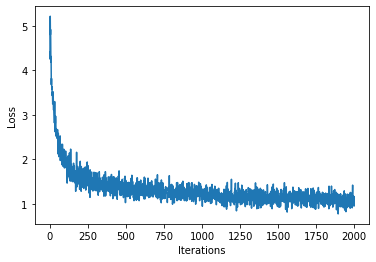

100%|██████████| 2000/2000 [2:03:04<00:00,  3.69s/it]


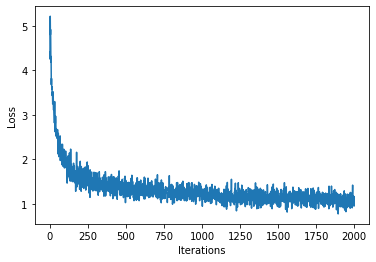

In [25]:
# Begin training

history = []
plotter = util.PeriodicPlotter(sec=2, xlabel='Iterations', ylabel='Loss')
if hasattr(tqdm, '_instances'): tqdm._instances.clear() # clear if it exists

for iter in tqdm(range(num_training_iterations)):
  # Grab a batch and propagete it through the network
  x_batch, y_batch = get_batch(vectorized_songs, seq_length, batch_size)
  loss = train_step(x_batch, y_batch)

  # Update the progress bar
  history.append(loss.numpy().mean())
  plotter.plot(history)

  # Update the model with the changed weights
  if iter % 100 == 0:
    model.save_weights(checkpoint_prefix)

# Save the trained model and the weights
model.save_weights(checkpoint_prefix)

### Generate music using the RNN model

Bây giờ, chúng ta có thể sử dụng *RNN model* đã được huấn luyện để phát sinh nhạc. Khi đang phát sinh nhạc, chúng ta sẽ cung cấp cho *model* một vài *seed* để bắt đầu (bởi vì nó không thể dự đoán bất kỳ điều gì khi không có gì để bắt đầu.  
Khi chúng ta có một *seed* được tạo ra, chúng ta có thể lặp đi lặp lại việc dự đoán cho mỗi ký tự kế tiếp (nên nhớ, chúng ta sử dụng ABC đại diện cho bản nhạc của chúng ta) bằng việc sử dụng *RNN model* đã được huấn luyện. Đặc biệt hơn, *RNN model* tạo ra một *softmax* trên các ký tự kế tiếp có thể. Để khởi tạo, chúng ta lặp đi lặp lại một mẫu từ các phân phối này, và sử dụng cho các mẫu để mã hóa một bài hát được tạo bởi định dạng *ABC*.  
Sau đó, chúng ta sẽ ghi chúng lên một file và nghe chúng.

### Restore the lates checkpoint

Để giữ cho bước suy luận đơn giản, chúng ta sử dụng một *batch_size* của 1. Bởi vì như thế *RNN state* sẽ được truyền từ thời điểm này đến thời điểm khác, *model*sẽ chỉ có thể chấp nhận *batch_size* cố định sau khi được xây dưng.  
Để thực thi *model* với *batch_size* khác nhau, chúng ta sẽ cần đến việc xây dựng lại *model* và lưu các trọng số từ lần *checkpoint* cuối cùng. 

In [26]:
# Rebuild the model using a batch_size = 1
model = build_model(vocab_size, embedding_dim, rnn_units, batch_size=1)
# Restore the model weights for the last checkpoint after training 
model.load_weights(tf.train.latest_checkpoint(checkpoint_dir))
model.build(tf.TensorShape([1, None]))
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (1, None, 256)            21248     
_________________________________________________________________
lstm_2 (LSTM)                (1, None, 1024)           5246976   
_________________________________________________________________
dense_2 (Dense)              (1, None, 83)             85075     
Total params: 5,353,299
Trainable params: 5,353,299
Non-trainable params: 0
_________________________________________________________________


Chúng ta chỉ cung cấp một *fixed batch_size* là 1 để suy luận

### The prediction procedure

Bâu giờ, chúng ta sẵn sàng để phát sinh một bản nhạc với định dạng ABC:
* Khởi tạo 1 "seed" bắt đầu chuỗi và *RNN state*, và cài đặt số ký tự bạn muốn phát sinh.
* Sử dụng chuỗi bắt đầu và *RNN state* để đạt được xác suất phân phối trên mỗi ký tự dự đã được dự đoán.
* Lấy mẫu từ nhân pphân phối để tính toán vị trí của ký tự được dự đoán. Với ký tự dự đoán này sau đó được sử dụng làm đầu vào tiếp theo cho mô hình.
* Tại mỗi thời điểm, *RNN state* đã được cập nhật để cung cấp ngược lại cho *model*, vì vậy nó có nhiều bối cảnh hơn cho việc đưa ra dự đoán tiếp theo. Sau khi dự đoán ký tự tiếp theo, *RNN states* đã được cập nhật sẽ lại được cung cấp cho model, đó là cách mà *model* học, nó sẽ học những trình tự phụ thuộc bên trong dữ liệu, khi nó nhận nhiều thông tin hơn từ kết quả dự đoán trước đó. 

![LSTM](https://camo.githubusercontent.com/7fe77db94dd40e1dfda455189f7064977d8b9946/68747470733a2f2f7261772e67697468756275736572636f6e74656e742e636f6d2f61616d696e692f696e74726f746f646565706c6561726e696e672f323031392f6c6162312f696d672f6c73746d5f696e666572656e63652e706e67)

Hoàn thành và thử nghiệm với khối mã này (cũng như một vài khía cạnh của định nghĩa và đào tạo mạng). và chúng ta thấy quá trình thực hiện của *model*. Bản nhạc đã được phát sinh như thế nào sau khi huấn luyện với một số lượng nhỏ *epochs* so sánh với bản nhạc được tạo ra sau một thời gian huấn luyện lâu hơn?

In [27]:
# Prediction of a generated song
def generate_text(model, start_string, generation_length=1000):
  # evaluation step (generating ABC text using the learned RNN model)
  
  #convert the start string to numbers (vectorize)
  input_eval = [char2idx[s] for s in start_string]
  input_eval = tf.expand_dims(input_eval, 0)

  # Empty string to store our results
  text_generated = []

  # Here batch_size == 1
  model.reset_states()
  tqdm._instances.clear()

  for i in tqdm(range(generation_length)):
    # evaluate the inputs and generate the next character predictions
    predictions = model(input_eval)
    # remove the batch dimension
    predictions = tf.squeeze(predictions, 0)
    # use a multinomial distribution to sample
    predicted_id = tf.random.categorical(predictions, num_samples=1)[-1, 0].numpy()
    # Pass the prediction along with the previous hidden state as the next input to the model
    input_eval = tf.expand_dims([predicted_id], 0)
    # add the predicted character to the generated text
    text_generated.append(idx2char[predicted_id])
  
  return (start_string + ''.join(text_generated))

In [28]:
'''
  Use the model and the function defined above to generate ABC format text of length 1000!
  As you may notice, ABC files start with "X" - this may be a good start string
'''
generated_text = generate_text(model, start_string="X", generation_length=1000)

100%|██████████| 1000/1000 [00:09<00:00, 102.85it/s]


### Play back the generated music

Chúng ta có thể gọi hàm chuyển văn bản định dạng *ABC* thành một file audio và sau đó phát lại để kiểm tra kết quả của chúng ta sau khi tạ nhạc. Hãy thử huấn luyện thời gian lâu hơn nếu bản nhạc kết quả không đủ dài.

In [29]:
# Play back generated songs
generated_songs = setup.extract_song_snippet(generated_text)
print(len(generated_songs))
for i, song in enumerate(generated_songs):
  # synthesize the waveform from a song
  waveform = setup.play_song(song)
  # if its a valid song (correct syntax), lets play it
  if waveform:
    print("Generated song", i)
    ipythondisplay.display(waveform)

Found 2 songs in text
2
